In [1]:
## ############################################################################
## ############################################################################
##
## Appendix A
##
## ############################################################################
## ############################################################################

##
## load necessary packages
##

# import and alias Pandas
import pandas as pd

# import and alias NumPy
import numpy as np

# import from the plotting package
import matplotlib as mpl
import matplotlib.pyplot as plt

# import from the linear regression package
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# import the MLB stats API
import statsapi

# import SQL package
import sqlite3

# map the various team names used to a consistent abbreviation
team_map = {
    'Arizona Diamondbacks': 'ARI',
    'Atlanta Braves' : 'ATL',
    'Baltimore Orioles': 'BAL',
    'Boston Red Sox': 'BOS',
    'Chicago Cubs': 'CHC',
    'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN',
    'Cleveland Guardians': 'CLE',
    'Cleveland Indians': 'CLE',
    'Colorado Rockies': 'COL',
    'Detroit Tigers': 'DET',
    'Houston Astros': 'HOU',
    'Kansas City Royals': 'KCR',
    'Los Angeles Angels of Anaheim': 'LAA',
    'Los Angeles Angels': 'LAA',
    'Los Angeles Dodgers': 'LAD',
    'Miami Marlins': 'MIA',
    'Milwaukee Brewers': 'MIL',
    'Minnesota Twins': 'MIN',
    'New York Mets': 'NYM',
    'New York Yankees': 'NYY',
    'Oakland A\'s': 'OAK',
    'Oakland Athletics': 'OAK',
    'Philadelphia Phillies': 'PHI',
    'Pittsburgh Pirates': 'PIT',
    'San Diego Padres': 'SDP',
    'Seattle Mariners': 'SEA',
    'San Francisco Giants': 'SFG',
    'St. Louis Cardinals': 'STL',
    'Tampa Bay Rays': 'TBR',
    'Texas Rangers': 'TEX',
    'Toronto Blue Jays': 'TOR',
    'Washington Nationals': 'WAS',
    'Diamondbacks': 'ARI',
    'Braves' : 'ATL',
    'Orioles': 'BAL',
    'Red Sox': 'BOS',
    'Cubs': 'CHC',
    'White Sox': 'CHW',
    'Reds': 'CIN',
    'Guardians': 'CLE',
    'Indians': 'CLE',
    'Rockies': 'COL',
    'Tigers': 'DET',
    'Astros': 'HOU',
    'Royals': 'KCR',
    'Angels': 'LAA',
    'Dodgers': 'LAD',
    'Marlins': 'MIA',
    'Brewers': 'MIL',
    'Twins': 'MIN',
    'Mets': 'NYM',
    'Yankees': 'NYY',
    'A\'s': 'OAK',
    'Athletics': 'OAK',
    'Phillies': 'PHI',
    'Pirates': 'PIT',
    'Padres': 'SDP',
    'Mariners': 'SEA',
    'Giants': 'SFG',
    'Cardinals': 'STL',
    'Rays': 'TBR',
    'Rangers': 'TEX',
    'Blue Jays': 'TOR',
    'Nationals': 'WAS'
}

# create the SQL database connection and cursor
conn = sqlite3.connect("standings.db")
sql = conn.cursor()    

In [2]:
##
## define a function to get league standings from the MLB Stats API
##

def league_standings (season, leagueId):

    # define the IDs for divisions
    eastIDs = [201, 204]
    centralIDs = [202, 205]
    westIDs = [200, 203]
        
    # get the specified season standings for the specified league
    league = statsapi.standings_data(leagueId = leagueId, season = season)
    
    # initialize the division winners and wildcard teams
    east_div = central_div = west_div = None
    wildcard_1 = wildcard_2 = wildcard_3 = None
    
    # for each division in the league standings
    for div in league:
    
        # for each team in the division standings
        for team in league[div]['teams']:

            # if it's a playoff team, save it in the correct spot
            east_div = team if div in eastIDs and team['div_rank'] == '1' else east_div
            central_div = team if div in centralIDs and team['div_rank'] == '1' else central_div
            west_div = team if div in westIDs and team['div_rank'] == '1' else west_div
            
            wildcard_1 = team if team['wc_rank'] == '1' else wildcard_1
            wildcard_2 = team if team['wc_rank'] == '2' else wildcard_2
            wildcard_3 = team if team['wc_rank'] == '3' else wildcard_3
    
    # build a dictionary from the saved teams
    teams = {
        "east_div": {'name': east_div['name'], 'wins': east_div['w']},
        "central_div": {'name': central_div['name'], 'wins': central_div['w']},
        "west_div": {'name': west_div['name'], 'wins': west_div['w']},
        "wildcard_1": {'name': wildcard_1['name'], 'wins': wildcard_1['w']},
        "wildcard_2": {'name': wildcard_2['name'], 'wins': wildcard_2['w']},
        "wildcard_3": {'name': wildcard_3['name'], 'wins': wildcard_3['w']}
    }

    return teams

##
## define a function to build a season standings DataFrame
##

def season_standings (season):
    
    # put the year in the dictionary
    standings = {'season': season}
    
    # define the IDs for the leagues
    leagues = {
        'al': 103,
        'nl': 104
    }

    # for each of the two leagues in MLB
    for league, leagueID in leagues.items():
    
        # get the standings for the league
        my_league_standings = league_standings(season, leagueID)
        
        # for each division in the league standings
        for division_key, division_value in my_league_standings.items():

            # for each team in the division standings
            for team_key, team_value in division_value.items():
                
                # add the column and value to the dictionary
                standings[f'{league}_{division_key}_{team_key}'] = team_value
                
    return pd.DataFrame([standings])

##
## build a DataFrame out of the standings for the years in question
##

# initialize the standings DataFrame
standings = pd.DataFrame()

# for each season
for season in [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]:

    # add a row to the DataFrame for the season
    standings = pd.concat([standings, season_standings(season)], ignore_index=True)

##
## store the DataFrame in a local SQL database
##

# write the dataframe into an SQL table
sql.execute('drop table if exists standings') 
standings.to_sql(name='standings', con=conn, index=False)

11

In [3]:
##
## Read the standings from an SQL database and preview the dataset
##

df_standings = pd.read_sql('select * from standings s', conn)

df_standings

,season,al_east_div_name,al_east_div_wins,al_central_div_name,al_central_div_wins,al_west_div_name,al_west_div_wins,al_wildcard_1_name,al_wildcard_1_wins,al_wildcard_2_name,...,nl_central_div_name,nl_central_div_wins,nl_west_div_name,nl_west_div_wins,nl_wildcard_1_name,nl_wildcard_1_wins,nl_wildcard_2_name,nl_wildcard_2_wins,nl_wildcard_3_name,nl_wildcard_3_wins
0,2013,Boston Red Sox,97,Detroit Tigers,93,Oakland Athletics,96,Cleveland Indians,92,Tampa Bay Rays,...,St. Louis Cardinals,97,Los Angeles Dodgers,92,Pittsburgh Pirates,94,Cincinnati Reds,90,Washington Nationals,86
1,2014,Baltimore Orioles,96,Detroit Tigers,90,Los Angeles Angels,98,Kansas City Royals,89,Oakland Athletics,...,St. Louis Cardinals,90,Los Angeles Dodgers,94,Pittsburgh Pirates,88,San Francisco Giants,88,Milwaukee Brewers,82
2,2015,Toronto Blue Jays,93,Kansas City Royals,95,Texas Rangers,88,New York Yankees,87,Houston Astros,...,St. Louis Cardinals,100,Los Angeles Dodgers,92,Pittsburgh Pirates,98,Chicago Cubs,97,San Francisco Giants,84
3,2016,Boston Red Sox,93,Cleveland Indians,94,Texas Rangers,95,Baltimore Orioles,89,Toronto Blue Jays,...,Chicago Cubs,103,Los Angeles Dodgers,91,New York Mets,87,San Francisco Giants,87,St. Louis Cardinals,86
4,2017,Boston Red Sox,93,Cleveland Indians,102,Houston Astros,101,New York Yankees,91,Minnesota Twins,...,Chicago Cubs,92,Los Angeles Dodgers,104,Arizona Diamondbacks,93,Colorado Rockies,87,Milwaukee Brewers,86
5,2018,Boston Red Sox,108,Cleveland Indians,91,Houston Astros,103,New York Yankees,100,Oakland Athletics,...,Milwaukee Brewers,96,Los Angeles Dodgers,92,Chicago Cubs,95,Colorado Rockies,91,St. Louis Cardinals,88
6,2019,New York Yankees,103,Minnesota Twins,101,Houston Astros,107,Oakland Athletics,97,Tampa Bay Rays,...,St. Louis Cardinals,91,Los Angeles Dodgers,106,Washington Nationals,93,Milwaukee Brewers,89,New York Mets,86
7,2021,Tampa Bay Rays,100,Chicago White Sox,93,Houston Astros,95,Boston Red Sox,92,New York Yankees,...,Milwaukee Brewers,95,San Francisco Giants,107,Los Angeles Dodgers,106,St. Louis Cardinals,90,Cincinnati Reds,83
8,2022,New York Yankees,99,Cleveland Guardians,92,Houston Astros,106,Toronto Blue Jays,92,Seattle Mariners,...,St. Louis Cardinals,93,Los Angeles Dodgers,111,New York Mets,101,San Diego Padres,89,Philadelphia Phillies,87
9,2023,Baltimore Orioles,101,Minnesota Twins,87,Houston Astros,90,Tampa Bay Rays,99,Texas Rangers,...,Milwaukee Brewers,92,Los Angeles Dodgers,100,Philadelphia Phillies,90,Miami Marlins,84,Arizona Diamondbacks,84


In [4]:
##
## Read a dataframe from a table on a web page.
## Clean it and store it into an SQL table.
##

# build the URL for SteveTheUmp
url = "https://www.stevetheump.com/Payrolls.htm"

# read the tables from the HTML
steve_the_ump = pd.read_html(url)

In [5]:
# map the various column names, the calendar year, and whether there's
# a header row for each of the HTML tables read from the page
table_info = {
    1: {
        'season': 2024,
        'team_column': 'TEAM',
        'payroll_column': 'TOTAL PAYROLL',
        'use_row_one_as_header': False
    },
    2: {
        'season': 2023,
        'team_column': 'Team',
        'payroll_column': 'Total Payroll',
        'use_row_one_as_header': True
    },
    3: {
        'season': 2022,
        'team_column': 'Team',
        'payroll_column': 'Total',
        'use_row_one_as_header': True
    },
    4: {
        'season': 2021,
        'team_column': 'Team',
        'payroll_column': 'Total',
        'use_row_one_as_header': True
    },
    6: {
        'season': 2019,
        'team_column': 'Team',
        'payroll_column': '25-Man Payroll',
        'use_row_one_as_header': True
    },
    7: {
        'season': 2018,
        'team_column': 'Team',
        'payroll_column': 'Payroll',
        'use_row_one_as_header': False
    },
    8: {
        'season': 2017,
        'team_column': 'Team',
        'payroll_column': 'Total Payroll',
        'use_row_one_as_header': True
    },
    9: {
        'season': 2016,
        'team_column': 'Team',
        'payroll_column': 'Opening Day',
        'use_row_one_as_header': False
    },
    10: {
        'season': 2015,
        'team_column': 'Team',
        'payroll_column': 'Payroll',
        'use_row_one_as_header': True
    },
    11: {
        'season': 2014,
        'team_column': '# Team',
        'payroll_column': 'Payroll',
        'use_row_one_as_header': True
    },
    12: {
        'season': 2013,
        'team_column': 'Team',
        'payroll_column': 'Payroll',
        'use_row_one_as_header': True
    }
}

# define a function to format the specified table
def season_payroll (table_index):
    
    # get the parameters from the mapping
    season = table_info[table_index]['season']
    team_column = table_info[table_index]['team_column']
    payroll_column = table_info[table_index]['payroll_column']
    use_row_one_as_header = table_info[table_index]['use_row_one_as_header']
    
    # get the specified tables from the page
    df = pd.DataFrame(steve_the_ump[table_index])
    
    # if row 1 is a header row, use it to name the columns
    if use_row_one_as_header:
        df.columns = df.iloc[0].tolist()
        df = df[1:]
    
    # get rid of any extra columns keeping only the team name and payroll
    df = df[[team_column,payroll_column]]
    
    # translate the team name into a consistent abbreviation
    df['team'] = df[team_column].str.lstrip(' .0123456789').replace(team_map)


    # format the payroll as a number
    df[season] = df[payroll_column] \
        .str \
        .replace(r'\$','',regex=True) \
        .replace(r',','',regex=True) \
        .replace(r'M','',regex=True)

    # get rid of any extra lines in the table
    df = df.dropna().query('~team.str.contains("League")')

    # handle the case where payrolls are given in millions
    df[season] = df.apply(lambda row: int(float(row[season]) * 1000000) if 'M' in row[payroll_column] else row[season], axis=1)

    # transpose the table so each year has all teams' payroll
    df = df[['team',season]].set_index('team').transpose()
    df = df.reset_index().rename(columns={'index':'year'})
    
    return df

# initialize the payrolls DataFrame
payrolls = pd.DataFrame()

# for each season
for table_index in table_info:

    # add a row to the DataFrame for the season
    payrolls = pd.concat([payrolls, season_payroll(table_index)])

# write the dataframe into an SQL table
sql.execute('drop table if exists payrolls') 
payrolls.to_sql(name='payrolls', con=conn, index=False)

11

In [6]:
##
## Read the payrolls from an SQL database and preview the dataset
##

df_payrolls = pd.read_sql('select * from payrolls p', conn)

df_payrolls

,year,NYM,NYY,HOU,PHI,ATL,TEX,TOR,LAD,CHC,...,WAS,DET,BAL,MIL,CIN,TBR,CLE,MIA,PIT,OAK
0,2024,301731074,293666666,237303141,236182617,225315000,221955000,221876784,220691666,216330000,...,95371429,95073933,94495168,94484960,88123333,88066012,86433928,83710000,72014000,47905000
1,2023,334233332,268954047,180888333,232424939,199727500,183578160,205680777,218332634,180115000,...,79983095,105338500,64907966,108644960,86374500,64652911,75010000,81075000,60787500,43145000
2,2022,253119999,240290714,163939599,221738462,173935000,134961333,168070905,277108333,130560000,...,114623095,116040000,30221166,122281128,99580000,75347813,42310000,69000000,37875000,32548334
3,2021,167415024,191205631,171018567,174009000,134459435,84868750,137133333,235412876,149665500,...,161907528,80398600,45701135,87569366,118748164,60388600,46833300,49425000,35905000,74615000
4,2019,91576770,118832077,147619666,131152962,89551043,104349564,54568171,99803334,194081714,...,154176081,97988900,61124882,108403700,106440714,49084731,88713833,69574714,54577502,84345833
5,2018,154610000,168540000,160040000,96850000,120540000,144000000,162316000,186140000,183460000,...,181590000,129919999,143090000,90240000,101190000,78730000,134350000,98640000,87880000,68530000
6,2017,155187460,201539699,124343900,111378000,112437541,175909063,177795368,242065828,172189880,...,167846918,199750600,163676616,63061300,93768785,69962532,124861165,111881100,100575946,81738333
7,2016,99626453,213472857,69064200,133048000,87622648,144307373,126369628,223352402,116654522,...,166010977,172282250,115587632,98683035,116732284,73649584,86339067,84637500,85885832,80279166
8,2015,101409244,219282196,70910100,135827500,97578565,142140873,122506600,272789040,119006885,...,164920505,173813750,110146097,105002536,117197072,76061707,86091175,68479000,88278500,86086667
9,2014,89051758,203812506,44544174,180052723,110897341,136036172,132628700,235295219,89007857,...,134704437,162228527,107406623,103844806,112390772,77062891,82534800,47565400,78111667,83401400


In [7]:
##
## build a DataFrame of the wins for the years in question
##

# define a function to build a season wins DataFrame
def season_wins (season):

    # create a new table for the data
    data = []
    
    # define the IDs for the leagues
    leagues = {
        'al': 103,
        'nl': 104
    }
    
    # for each of the two leagues in MLB
    for league, leagueID in leagues.items():
        
        # get the divisions for the league
        my_league = statsapi.standings_data(leagueId = leagueID, season = season)
        
        # for each division in the league
        for division_key, division_value in my_league.items():
            
            # for each team in the division standings
            for team in division_value['teams']:
                
                # note whether the team made the playoffs
                playoffs = 1 if team['wc_rank'] in ['-','1','2','3'] else 0
        
                # add a line to the table
                data.append([season, league, f"{team['name']}", team['w'], playoffs])
        
    # build a data frame from the table
    df = pd.DataFrame(data, columns=['year', 'league', 'team_name', 'wins', 'playoffs'])
    
    # map the team names into their abbreviations
    df['team'] = df['team_name'].replace(team_map)
    
    return pd.DataFrame(df[['year', 'league', 'team', 'wins', 'playoffs']])

# initialize the wins DataFrame
wins = pd.DataFrame()

# for each season
for season in [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]:

    # add the wins for the season to the dataframe
    wins = pd.concat([wins, season_wins(season)], ignore_index=True)

# write the dataframe into an SQL table
sql.execute('drop table if exists wins') 
wins.to_sql(name='wins', con=conn, index=False)

330

In [8]:
##
## Read the wins from an SQL database, add flags for LCS and WS, and preview the dataset
##

df_wins = pd.read_sql('select * from wins w', conn)

## build a list of League Championship Series and World Series appearances
later_rounds = []

# AL
later_rounds.append([2013, 'BOS', 1, 1])
later_rounds.append([2013, 'DET', 1, 0])
later_rounds.append([2014, 'KCR', 1, 1])
later_rounds.append([2014, 'BAL', 1, 0])
later_rounds.append([2015, 'KCR', 1, 1])
later_rounds.append([2015, 'TOR', 1, 0])
later_rounds.append([2016, 'CLE', 1, 1])
later_rounds.append([2016, 'TOR', 1, 0])
later_rounds.append([2017, 'HOU', 1, 1])
later_rounds.append([2017, 'NYY', 1, 0])
later_rounds.append([2018, 'BOS', 1, 1])
later_rounds.append([2018, 'HOU', 1, 0])
later_rounds.append([2019, 'HOU', 1, 1])
later_rounds.append([2019, 'NYY', 1, 0])
later_rounds.append([2021, 'HOU', 1, 1])
later_rounds.append([2021, 'BOS', 1, 0])
later_rounds.append([2022, 'HOU', 1, 1])
later_rounds.append([2022, 'NYY', 1, 0])
later_rounds.append([2023, 'TEX', 1, 1])
later_rounds.append([2023, 'HOU', 1, 0])
later_rounds.append([2024, 'NYY', 1, 1])
later_rounds.append([2024, 'CLE', 1, 0])

# NL
later_rounds.append([2013, 'STL', 1, 1])
later_rounds.append([2013, 'LAD', 1, 0])
later_rounds.append([2014, 'SFG', 1, 1])
later_rounds.append([2014, 'STL', 1, 0])
later_rounds.append([2015, 'NYM', 1, 1])
later_rounds.append([2015, 'CHC', 1, 0])
later_rounds.append([2016, 'CHC', 1, 1])
later_rounds.append([2016, 'LAD', 1, 0])
later_rounds.append([2017, 'LAD', 1, 1])
later_rounds.append([2017, 'CHC', 1, 0])
later_rounds.append([2018, 'LAD', 1, 1])
later_rounds.append([2018, 'MIL', 1, 0])
later_rounds.append([2019, 'WAS', 1, 1])
later_rounds.append([2019, 'STL', 1, 0])
later_rounds.append([2021, 'ATL', 1, 1])
later_rounds.append([2021, 'LAD', 1, 0])
later_rounds.append([2022, 'PHI', 1, 1])
later_rounds.append([2022, 'SDP', 1, 0])
later_rounds.append([2023, 'ARI', 1, 1])
later_rounds.append([2023, 'PHI', 1, 0])
later_rounds.append([2024, 'LAD', 1, 1])
later_rounds.append([2024, 'NYM', 1, 0])

# build a data frame from the table
df_later_rounds = pd.DataFrame(later_rounds, columns=['year', 'team', 'lcs', 'ws'])

# merge it onto the wins dataset
df_wins = pd.merge(
    df_wins,
    df_later_rounds,
    on=['year', 'team'],
    how='left'
).fillna(0)

# cast new indicators as int flags
df_wins.lcs = df_wins.lcs.astype(int)
df_wins.ws = df_wins.ws.astype(int)

# preview the dataset
df_wins

,year,league,team,wins,playoffs,lcs,ws
0,2013,al,BOS,97,1,1,1
1,2013,al,TBR,92,1,0,0
2,2013,al,NYY,85,0,0,0
3,2013,al,BAL,85,0,0,0
4,2013,al,TOR,74,0,0,0
...,...,...,...,...,...,...,...
325,2024,nl,LAD,98,1,1,1
326,2024,nl,SDP,93,1,0,0
327,2024,nl,ARI,89,0,0,0
328,2024,nl,SFG,80,0,0,0


In [9]:
##
## build a master dataset by joining the wins and payroll
##

# merge on year/team to create master data
df_pristine = pd.merge(
    df_wins,
    df_payrolls \
    .melt(id_vars=['year']) \
    .rename(columns={'variable': 'team', 'value': 'payroll'}),
    on=['year', 'team']
)

# calculate payroll in millions
df_pristine['payroll_M'] = df_pristine.payroll.astype(int) / 1000000

# create a working copy of the master data, just in case
data = df_pristine.copy()

# preview the working copy
data

,year,league,team,wins,playoffs,lcs,ws,payroll,payroll_M
0,2013,al,BOS,97,1,1,1,150655500,150.655500
1,2013,al,TBR,92,1,0,0,57895272,57.895272
2,2013,al,NYY,85,0,0,0,228835490,228.835490
3,2013,al,BAL,85,0,0,0,90993333,90.993333
4,2013,al,TOR,74,0,0,0,117527800,117.527800
...,...,...,...,...,...,...,...,...,...
325,2024,nl,LAD,98,1,1,1,220691666,220.691666
326,2024,nl,SDP,93,1,0,0,153765453,153.765453
327,2024,nl,ARI,89,0,0,0,156511716,156.511716
328,2024,nl,SFG,80,0,0,0,188767909,188.767909


In [10]:
##
## How many wins does it take to make the playoffs?
##

## The nature of playoff selection in MLB makes this question a little
## bit trickier to answer than it might seem, since:
## a) a division winner might have fewer wins than a wildcard team, and
## b) the threshold is different between the American and National Leagues.
##
## We'll plot four lines:
## a) the lowest number of wins for a playoff team in the AL,
## b) the lowest number of wins for a playoff team in the NL,
## c) the highest number of wins for a non-playoff team in the AL, and
## d) the highest number of wins for a non-playoff team in the NL.
##

## get the lowest number of wins for a playoff team in the AL each year
al_playoffs_min = data.query('league == "al" and playoffs == 1') \
    .groupby(['year']) \
    .agg(al_playoffs_min = ('wins', 'min'))

## get the highest number of wins for a non-playoff team in the AL each year
al_non_playoffs_max = data.query('league == "al" and playoffs == 0') \
    .groupby(['year']) \
    .agg(al_non_playoffs_max = ('wins', 'max'))

## get the lowest number of wins for a playoff team in the NL each year
nl_playoffs_min = data.query('league == "nl" and playoffs == 1') \
    .groupby(['year']) \
    .agg(nl_playoffs_min = ('wins', 'min'))

## get the highest number of wins for a non-playoff team in the NL each year
nl_non_playoffs_max = data.query('league == "nl" and playoffs == 0') \
    .groupby(['year']) \
    .agg(nl_non_playoffs_max = ('wins', 'max'))

# merge on year to create master data
al = pd.merge(al_playoffs_min, al_non_playoffs_max, on=['year'])
nl = pd.merge(nl_playoffs_min, nl_non_playoffs_max, on=['year'])
df = pd.merge(al, nl, on=['year']).reset_index()

df

,year,al_playoffs_min,al_non_playoffs_max,nl_playoffs_min,nl_non_playoffs_max
0,2013,91,86,86,81
1,2014,87,85,82,79
2,2015,85,83,84,83
3,2016,86,86,86,79
4,2017,80,80,86,83
5,2018,90,89,88,82
6,2019,93,84,86,85
7,2021,91,90,83,82
8,2022,86,83,87,86
9,2023,87,88,84,83


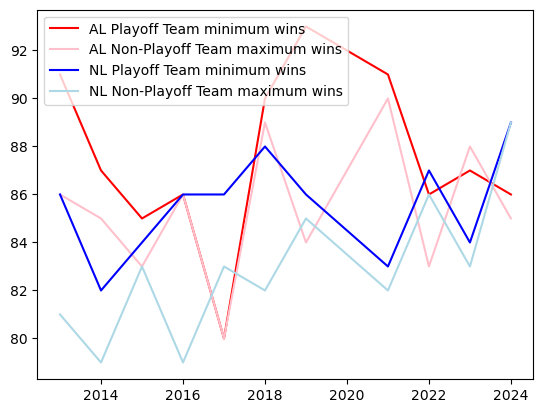

In [11]:
 # plot lines
plt.plot(df.year, df.al_playoffs_min, label='AL Playoff Team minimum wins', color='red')
plt.plot(df.year, df.al_non_playoffs_max, label='AL Non-Playoff Team maximum wins', color='pink')
plt.plot(df.year, df.nl_playoffs_min, label='NL Playoff Team minimum wins', color='blue')
plt.plot(df.year, df.nl_non_playoffs_max, label='NL Non-Playoff Team maximum wins', color='lightblue')
plt.legend()
plt.show()

In [12]:
 # mean minimum number of wins for playoff teams over the years
((df.al_playoffs_min + df.nl_playoffs_min) / 2).mean()

86.5

In [13]:
# mean minimum number of wins for AL playoff teams over the years
df.al_playoffs_min.mean()

87.45454545454545

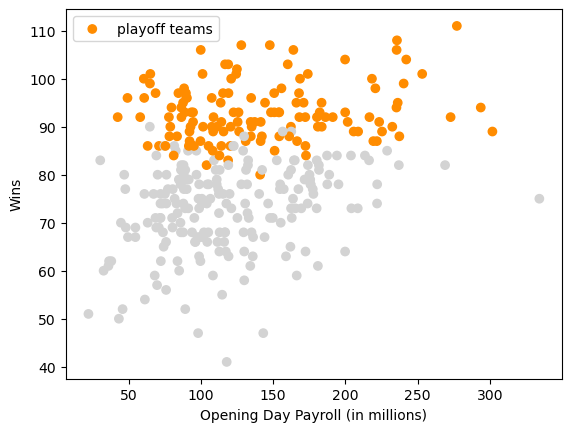

In [14]:
# plot to look for evidence that there's a low-end payroll for playoff teams
plt.scatter(
    data.payroll_M,
    data.wins,
    c=data.playoffs,
    cmap=mpl.colors.ListedColormap(['lightgray', 'darkorange'])
)

plt.legend(['playoff teams'])
plt.ylabel('Wins')
plt.xlabel('Opening Day Payroll (in millions)')
plt.show()

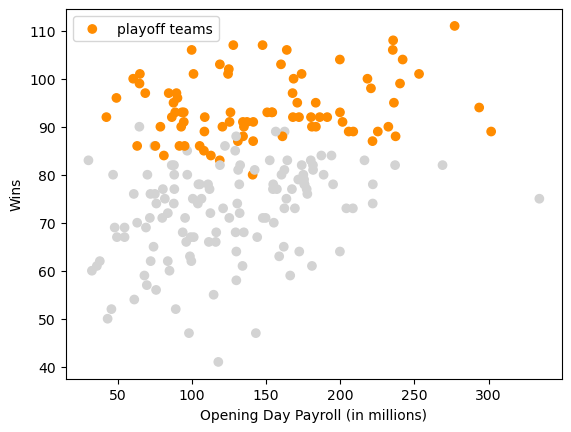

In [15]:
# Same plot but drop off the 4 oldest seasons
df = data.query('year > 2016')

plt.scatter(
    df.payroll_M,
    df.wins,
    c=df.playoffs,
    cmap=mpl.colors.ListedColormap(['lightgray', 'darkorange'])
)
plt.legend(['playoff teams', 'non-playoff teams'])
plt.ylabel('Wins')
plt.xlabel('Opening Day Payroll (in millions)')
plt.show()

In [16]:
# find those really low-end payroll outliers!
data.query('year > 2016 and wins > 90 and payroll_M < 50')

,year,league,team,wins,playoffs,lcs,ws,payroll,payroll_M
181,2019,al,TBR,96,1,0,0,49084731,49.084731
245,2022,al,CLE,92,1,0,0,42310000,42.310000


In [17]:
##
## define a function to predict wins based on Opening Day payroll
##

def predicted_wins(title, train, test):
    
    # prep the linear regression datasets
    X_train = pd.DataFrame(train.payroll_M)
    y_train = pd.DataFrame(train.wins)
    X_test = pd.DataFrame(test.payroll_M)
    y_test = pd.DataFrame(test.wins)
    
    # create and train linear regression model
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    # make predictions using the testing set
    y_pred = lr.predict(X_test)
    
    # the coefficients
    print('Training data points: ', len(X_train))
    print('Test data points: ', len(X_test))
    print('Coefficient: ', lr.coef_)
    print('Intercept: ', lr.intercept_)
    
    # the mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    
    # the coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    
    # plot outputs
    plt.scatter(X_test, y_test, color="black")
    plt.plot(X_test, y_pred, color="slateblue", linewidth=0.5)
    plt.title(title)
    plt.xlabel('Opening Day Payroll (in millions)')
    plt.ylabel('Predicted wins')
    plt.show()

Training data points:  270
Test data points:  60
Coefficient:  [[0.09295002]]
Intercept:  [69.62916818]
Mean squared error: 165.52
Coefficient of determination: -0.05


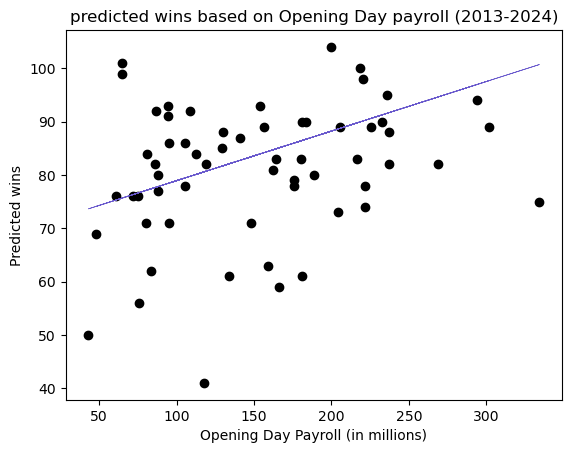

In [18]:
title = 'predicted wins based on Opening Day payroll (2013-2024)'
train = data.query('year < 2023')
test = data.query('year >= 2023')
predicted_wins(title, train, test)

Training data points:  120
Test data points:  60
Coefficient:  [[0.11491481]]
Intercept:  [66.69852841]
Mean squared error: 179.64
Coefficient of determination: -0.13


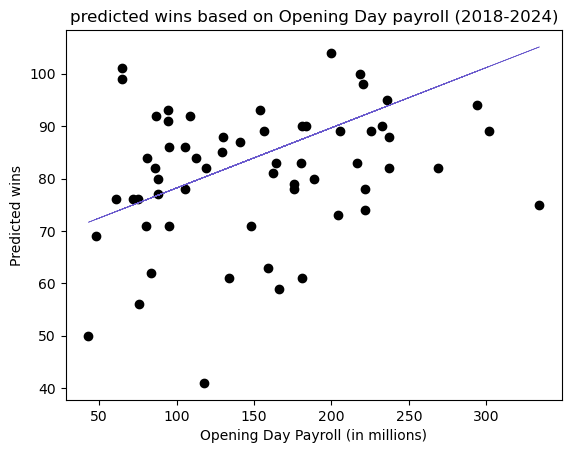

In [19]:
title = 'predicted wins based on Opening Day payroll (2018-2024)'
train = data.query('year > 2017 and year < 2023')
test = data.query('year >= 2023')
predicted_wins(title, train, test)

In [20]:
 ## define a function to scatterplot based on a target variable
def scatterplot_with_target(target, caption, yes_legend, no_legend):
    
    # split the data set based on the target variable
    no_class = data.query(f'{target} == 0')
    yes_class = data.query(f'{target} == 1')
    
    # plot the "no" class
    plt.scatter(
        no_class.year,
        no_class.payroll_M,
        alpha = 0.2,
        color = 'gray'
    )
    
    # plot the "yes" class
    plt.scatter(
        yes_class.year,
        yes_class.payroll_M,
        alpha = 0.8,
        color = 'darkorange'
    )
    
    # add the title and axis labels
    plt.title(f'Does a higher payroll make the {caption} more likely?')
    plt.xlabel('Year')
    plt.ylabel('Opening Day Payroll (in millions)')
    
    # add a legend
    plt.legend([f'{no_legend}' , f'{yes_legend}'])
    
    plt.show()

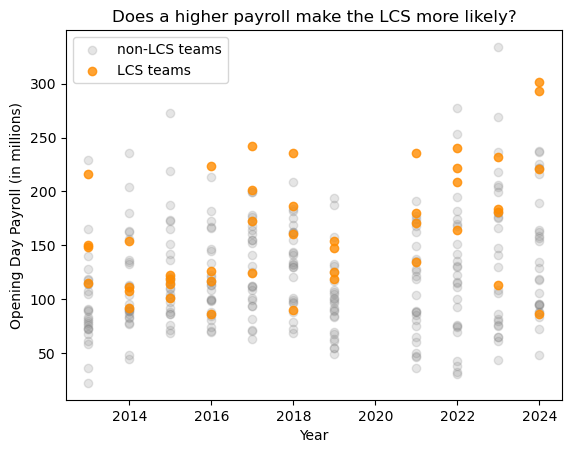

In [21]:
scatterplot_with_target('lcs', 'LCS', 'LCS teams', 'non-LCS teams')

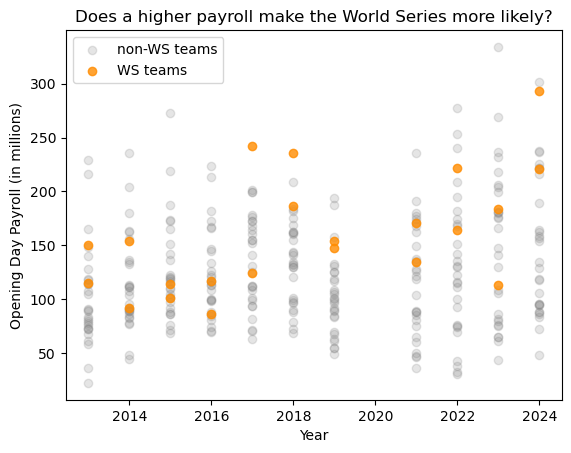

In [22]:
scatterplot_with_target('ws', 'World Series', 'WS teams', 'non-WS teams')

In [23]:
##
## Is there any evidence that a higher payroll is better?
##

df = data.query('year > 2020 and payroll_M >= 150')

print ('Since 2020,', len(df), 'teams have had an Opening Day payroll of at least $150M')
print (sum(df.playoffs), 'have made it into playoffs (out of 48 total playoff teams)')
print (sum(df.lcs), 'have made it into the League Championship Series (out of 16 total LCS teams)')
print (sum(df.ws), 'have made it into the World Series (out of 8 total WS teams)')

Since 2020, 51 teams have had an Opening Day payroll of at least $150M
26 have made it into playoffs (out of 48 total playoff teams)
13 have made it into the League Championship Series (out of 16 total LCS teams)
6 have made it into the World Series (out of 8 total WS teams)
